## Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)
# from tensorflow import keras

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import category_encoders as ce
import tensorflow.keras.backend as K
print("GPU Available: ", tf.test.is_gpu_available())


# import lux
import pandas as pd

2.1.0
GPU Available:  False


## Helper Methods

In [16]:
output_column = 'LE_bowen_corr_mm'
def read_data():
        file_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
        df = pd.read_csv(file_path, delimiter=',')

        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)',
                         'ET_bowen_corr_mm', 'ETo', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6']


        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        df = df[df[output_column].between(1, 15)]

        #Generate 5 lags
        lagsForColumns = ["SW_IN", "WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI"]
        df = generate_lags(df, lagsForColumns)
        df.dropna(inplace=True)

        #Binary Encode Site Id
        df = binary_encode_column(df, "Site")

        #Drop columns
        df.drop(columns=['Site_0'], inplace=True)
        return df

def binary_encode_column(df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def generate_lags_for(df, column, lags_count): 
            for i in range(lags_count):
                lag_name = column + "-" + str(i + 1)
                df[lag_name] = df[column].shift(i + 1)
            return df

def generate_lags(df, lagsForColumns):
        for k in range(len(lagsForColumns)):
            col = lagsForColumns[k]
            if col in df.columns:
                df = generate_lags_for(df, col, 5)
        return df
    
    
def split_train_test(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, Y_train, X_test, Y_test

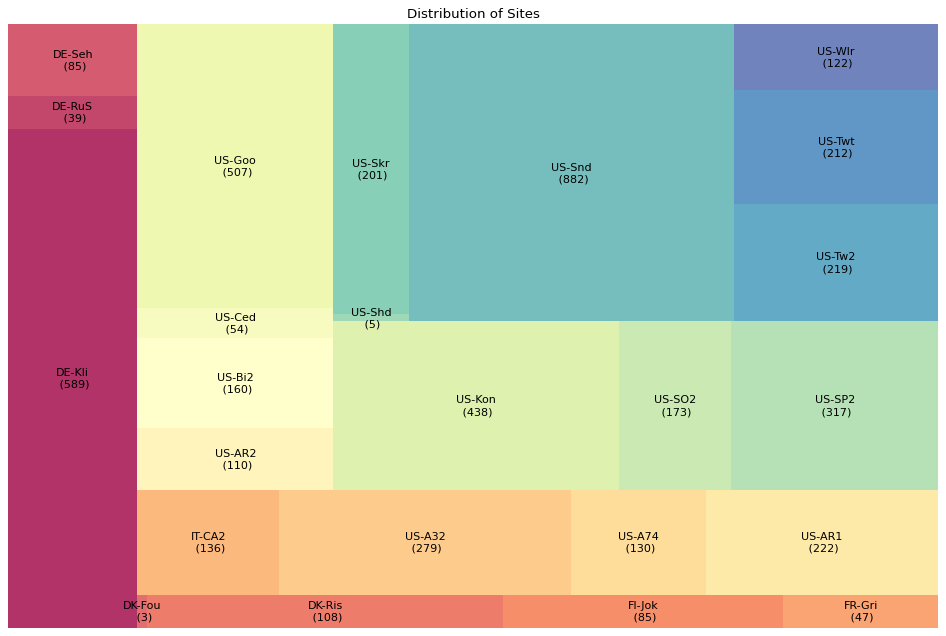

In [14]:
import squarify 

df = read_data()
df
# columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
#            'Date', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
#         'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
#        'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
#        'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
#        'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
#        'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
#        'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
#        'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
#        'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
#        'EEflux Albedo-5', 'LE_bowen_corr(mm)']
# df = df[columns]

# Prepare Data
df_grouped = df.groupby('Site').size().reset_index(name='counts')
labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_grouped['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(15, 10), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Distribution of Sites')
plt.axis('off')
plt.show()

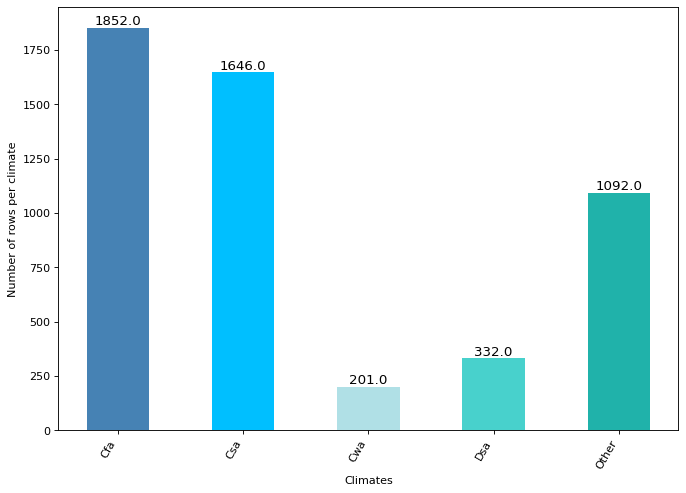

In [47]:
import random

df = read_data()
# columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
#            'Date', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
#         'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
#        'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
#        'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
#        'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
#        'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
#        'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
#        'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
#        'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
#        'EEflux Albedo-5', 'LE_bowen_corr(mm)']
# df = df[columns]

studied_column = "Climate"

df_grouped = df.groupby(studied_column).size().reset_index(name='counts')
n = df_grouped[studied_column].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(10, 7), dpi= 80)
plt.bar(df_grouped[studied_column], df_grouped['counts'], color=['steelblue', 'deepskyblue', 'powderblue', 'mediumturquoise', 'lightseagreen'], width=.5)
for i, val in enumerate(df_grouped['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df_grouped[studied_column], rotation=60, horizontalalignment= 'right')
# plt.title("Number of Vehicles by Manaufacturers", fontsize=22)
plt.xlabel('Climates')
plt.ylabel('Number of rows per climate')
# plt.ylim(0, 45)
plt.show()

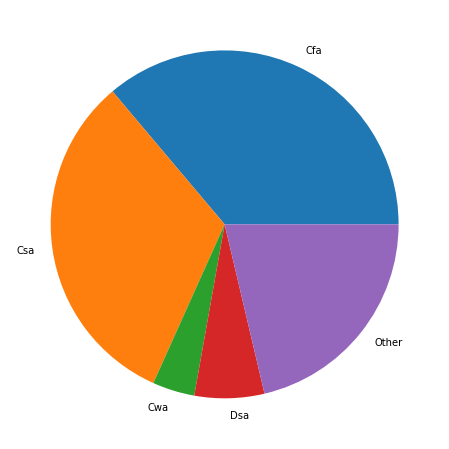

In [19]:
df = read_data()
# columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
#            'Date', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
#         'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
#        'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
#        'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
#        'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
#        'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
#        'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
#        'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
#        'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
#        'EEflux Albedo-5', 'LE_bowen_corr(mm)']
# df = df[columns]

studied_column = "Climate"

df_grouped = df.groupby(studied_column).size()

# Make the plot with pandas
df_grouped.plot(kind='pie', subplots=True, figsize=(8, 8))
# plt.title("Pie Chart of Vehicle Class - Bad")
plt.ylabel("")
plt.show()


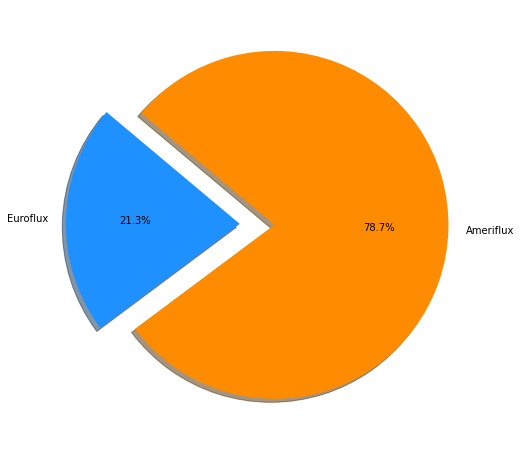

In [32]:
df = read_data()
# columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
#            'Date', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
#         'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
#        'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
#        'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
#        'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
#        'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
#        'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
#        'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
#        'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
#        'EEflux Albedo-5', 'LE_bowen_corr(mm)']
# df = df[columns]

df["Data Sources"] = 1
df['Type'] = np.where(df['Climate'] =='Other', "Ameriflux", "Euroflux")

studied_column = "Type"

df.groupby(studied_column).sum().plot(kind='pie', y='Data Sources',
                   subplots=True, legend=False,
                   labels = ['Euroflux', 'Ameriflux'],
                   colors = ['dodgerblue', 'darkorange'],
                   autopct='%1.1f%%', explode=(0.1, 0.1),
                   shadow=True, startangle=140, figsize=(8, 8))

plt.ylabel("")
plt.show()
# df.groupby(['TYPE']).sum().plot(kind='pie', y='SALES', shadow = True)


# plot = df.plot.pie(y='hours', title="Title", legend=False, \
#                    autopct='%1.1f%%', explode=(0, 0, 0.1), \
#                    shadow=True, startangle=0)
# plt.title("Data Source of Sites")
# 

In [29]:
df = read_data()
columns = ['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
           'Date', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
        'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5', 'LE_bowen_corr(mm)']
df = df[columns]